In [26]:
!pip install einops

In [ ]:
# Core libraries
import os
import numpy as np
from PIL import Image
from einops import rearrange
# PyTorch and torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import einsum
# Utility for progress bars
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt


In [ ]:
# Custom dataset for mask images (single-channel or RGB)
class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, fname), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Update these paths to your new dataset location
base_dir = '/content/drive/MyDrive/predicted_over22'
train_dir = os.path.join(base_dir, 'Train2')
val_dir = os.path.join(base_dir, 'Val2')
test_dir = os.path.join(base_dir, 'Test2')

img_size = 224
batch_size = 16

# Define image transformations (resize, tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
# Instantiate datasets
train_dataset = MaskDataset(train_dir, transform=transform)
val_dataset = MaskDataset(val_dir, transform=transform)
test_dataset = MaskDataset(test_dir, transform=transform)

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
# Print class mapping and distribution
num_classes = len(train_dataset.class_to_idx)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_dataset.class_to_idx)

# Optional: Check class distribution
class_counts = {}
for _, label in train_dataset.samples:
    class_counts[label] = class_counts.get(label, 0) + 1
print("Class distribution:", class_counts)


In [ ]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


In [ ]:
#In LayerNorm, we normalize each token by itself.
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        #return self.fn(self.norm(x), **kwargs)     #PreNorm for version 1
        return self.norm(self.fn(x, **kwargs))      #PostNorm for version 2

In [ ]:
class FeedForward(nn.Module):
    # mlp_dim = hidden_dim * 4 where dim=hidden_dim=(96,192,384,768)->channels

    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def create_mask(window_size, displacement, upper_lower, left_right):            #To handle cycle patches
    mask = torch.zeros(window_size ** 2, window_size ** 2)                      # (49,49)(window size=7 so matrix size would be 49X49)
    print('original mask: ', mask)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')  # down left section
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')  # up right section

    if left_right:                                                                           #to handle last vertical patches
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


In [ ]:
#example
create_mask(window_size=3, displacement=1, upper_lower=False, left_right=True)


In [ ]:
def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    #print('indices: ', indices.size())   # (49, 2) [0,0], [0,1], ..., [0,6], ..., [6,6]

    distances = indices[None, :, :] - indices[:, None, :]
    return distances


In [ ]:
#window_size is 7
class WindowAttention(nn.Module):
  def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
    #dim=hidden_dim=(96,192,384,768) channels
    #heads=num_heads=(3,6,12,14)
    #head_dim=32 (head_dim*heads = channels)
    super().__init__()
    inner_dim = head_dim * heads                  #(32*3=96, 32*6=192, 32*12=384, 32*14=768) = C
    self.heads = heads
    self.scale = head_dim ** -0.5
    self.window_size = window_size
    self.relative_pos_embedding = relative_pos_embedding
    self.shifted = shifted
    if self.shifted:
      displacement = window_size // 2       #7//2=3
      self.cyclic_shift = CyclicShift(-displacement)
      self.cyclic_back_shift = CyclicShift(displacement)

      #(49,49): masks are NOT learnable parameters; requires_grad=False
      self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement, upper_lower=True, left_right=False), requires_grad=False)
      self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement, upper_lower=False, left_right=True), requires_grad=False)

    self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
    # dim = (96, 192, 384, 768) and (inner_dim = head_dim * heads); we can also use C*3 and gives us same thing

    if self.relative_pos_embedding:
      self.relative_indices = get_relative_distances(window_size) + window_size - 1
      self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
      # (13, 13) because if I am on one cell I have 6 possible relationship behind and after
    else:
      self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))  # (49, 49) this is absolute

    self.to_out = nn.Linear(inner_dim, dim)
    # inner_dim = head_dim*heads = C, dim=hidden_dim=(96,192,384,768)

  def forward(self, x):
    if self.shifted:
      # print('x size: ', x.size())  #(1, (56,28,14,7), (56,28,14,7), (96,192,384,768))
      x = self.cyclic_shift(x)
      # print('x size: ', x.size())  #(1, (56,28,14,7), (56,28,14,7), (96,192,384,768))

    b, n_h, n_w, _, h = *x.shape, self.heads
    # print('x shape: ', x.shape)

    # print('self.to_qkv(x): ', self.to_qkv(x).size())
    qkv = self.to_qkv(x).chunk(3, dim=-1)
    # print('qkvs: ', qkv[0].size())
    # (1, (56,28,14,7), (56,28,14,7), (96,192,384,768)) for qkv[0] as qkv is a tuple

    nw_h = n_h // self.window_size
    nw_w = n_w // self.window_size
    # (56//7=8, 28//7=4, 14//7=2, 7//7=1)

    q, k, v = map(lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d', h=self.heads, w_h=self.window_size, w_w=self.window_size),qkv)
    #print('q size: ', q.size())
    #(b=1, h=(3,6,12,24), (nw_h*nw_w)=(64,16,4,1), (w_h*w_w)=49, d=32) where d=head_dim; h=#heads;
    #print('k size: ', k.size())     # same as q
    #print('v size: ', v.size())     # same as q

    #Dot Product Similarity
    dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale
    # b=batch_size, h=#heads (3, 6, 12, 24), w=(64, 16, 4, 1), i=49, j=49

    if self.relative_pos_embedding:
      #print('self.pos_embedding: ', self.pos_embedding)           # (13, 13)
      tmp1 = self.relative_indices[:, :, 0]     # (49, 49) as relative_indices is (49, 49, 2)

      #tmp2 = self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]] #(49, 49)
      #print(tmp2.size())
      dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]  # b=batch_size, h=#heads (3, 6, 12, 24), w=(64, 16, 4, 1), i=49, j=49
    else:
      dots += self.pos_embedding    # b=batch_size, h=#heads (3, 6, 12, 24), w=(64, 16, 4, 1), i=49, j=49



    if self.shifted:
      #tmp1 = self.upper_lower_mask         # (49, 49)
      #tmp2 = self.left_right_mask          # (49, 49)
      dots[:, :, -nw_w:] += self.upper_lower_mask
      dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

    attn = dots.softmax(dim=-1)
    # b=batch_size, h=#heads (3, 6, 12, 24), w=(64, 16, 4, 1), i=49, j=49

    out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
    #(b=1, h=(3,6,12,24), (nw_h*nw_w)=(64,16,4,1), (w_h*w_w)=49, d=32) where d=head_dim; h=#heads;

    out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)', h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
    # (1, (56,28,14,7), (56,28,14,7), (96,192,384,768))

    out = self.to_out(out)  # (1, (56,28,14,7), (56,28,14,7), (96,192,384,768))

    if self.shifted:
      out = self.cyclic_back_shift(out)  # (1, (56,28,14,7), (56,28,14,7), (96,192,384,768))

    return out


In [ ]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        # dim = hidden_dim=(96, 192, 384, 768); #heads=num_heads=(3, 6, 12, 24); mlp_dim = hidden_dim * 4
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))

        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


In [ ]:
class PatchMerging_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()

        self.patch_merge = nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=downscaling_factor,
                                     stride=downscaling_factor,
                                     padding=0)

    def forward(self, x):
        # print('x.size: ', x.size())
        # x = self.patch_merge(x)
        x = self.patch_merge(x).permute(0, 2, 3, 1)
        return x


In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)  # output_channels = hidden_dim = 96

    def forward(self, x):
        b, c, h, w = x.shape                                  # (1, (3,96,192,384), (224,56,28,14), (224,56,28,14))
        #print('x.size(): ', x.size())
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor       #(56,28,14,7)
        #print('new_h: ', new_h)
        #print('new_w: ', new_w)

        tmp_patch_merge = self.patch_merge(x)                       # (1, (48,384,768,1536), (3136,784,196,49))
        #print('tmp_patch_merge.size(): ', tmp_patch_merge.size())
        tmp_view = self.patch_merge(x).view(b, -1, new_h, new_w)    # (1, (48,384,768,1536), (56,28,14,7), (56,28,14,7))
        #print('tmp_view.size(): ', tmp_view.size())
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)   # (1, (56,28,14,7), (56,28,14,7), (48,384,768,1536))
        #print('x before: ', x.size())
        x = self.linear(x)                                            # (1, (56,28,14,7), (56,28,14,7), (96,192,384,768))
        #print('x after: ', x.size())
        return x


In [ ]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor,
                 num_heads, head_dim, window_size, relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        #self.patch_partition = PatchMerging_Conv(in_channels=in_channels, out_channels=hidden_dimension,downscaling_factor=downscaling_factor)
        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        #print('before patch merging: ', x.size())
        x = self.patch_partition(x)
        #print('after patch merging: ', x.size())
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)

        return x.permute(0, 3, 1, 2)


In [ ]:
class SwinTransformer(nn.Module):
    def __init__(
        self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
        downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True
    ):
        super().__init__()

        self.stage1 = StageModule(
            in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
            downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding
        )
        self.stage2 = StageModule(
            in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
            downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding
        )
        self.stage3 = StageModule(
            in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
            downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding
        )
        self.stage4 = StageModule(
            in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
            downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Dropout(0.3),  # Dropout with 30% probability (you can adjust)
            nn.Linear(hidden_dim * 8, num_classes)

        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)


In [ ]:
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = swin_t(
    hidden_dim=96,
    layers=(2,2,6,2),
    heads=(3,6,12,24),
    channels=3,  # Use 1 if your masks are single-channel and you adjust the model accordingly
    num_classes=num_classes,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4,2,2,2),
    relative_pos_embedding=True
)
model = model.to(device)

# Print model summary
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {train_dataset.class_to_idx}")


In [ ]:
net = swin_t(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=3,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)

dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)   # (1, 3)
#print(net)
print(logits)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
num_epochs = 30
best_val_acc = 0.0
checkpoint_interval = 3  # Save checkpoint every 3 epochs

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


In [23]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / total_val
    val_acc = 100. * correct_val / total_val

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'train_loss': train_loss,
            'history': history
        }, "best_swin_predicted_mask.pth")
        print(f"Saved new best model with val acc: {val_acc:.2f}%")

    # Save checkpoint every 3 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history
        }, checkpoint_path)
        print(f"Saved checkpoint at epoch {epoch+1} to {checkpoint_path}")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/30 [Val]: 100%|██████████| 22/22 [05:23<00:00, 14.70s/it]


Epoch 1/30 | Train Loss: 0.8167 | Train Acc: 49.22% | Val Loss: 0.9029 | Val Acc: 36.78%
Saved new best model with val acc: 36.78%


Epoch 2/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


Epoch 2/30 | Train Loss: 0.5744 | Train Acc: 68.71% | Val Loss: 0.1502 | Val Acc: 96.26%
Saved new best model with val acc: 96.26%


Epoch 3/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.21it/s]


Epoch 3/30 | Train Loss: 0.1207 | Train Acc: 96.88% | Val Loss: 0.0879 | Val Acc: 98.28%
Saved new best model with val acc: 98.28%
Saved checkpoint at epoch 3 to checkpoint_epoch_3.pth


Epoch 4/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.58it/s]


Epoch 4/30 | Train Loss: 0.0861 | Train Acc: 98.25% | Val Loss: 0.0785 | Val Acc: 97.99%


Epoch 5/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.44it/s]


Epoch 5/30 | Train Loss: 0.0840 | Train Acc: 98.05% | Val Loss: 0.0843 | Val Acc: 97.99%


Epoch 6/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]


Epoch 6/30 | Train Loss: 0.0886 | Train Acc: 98.05% | Val Loss: 0.0806 | Val Acc: 98.28%
Saved checkpoint at epoch 6 to checkpoint_epoch_6.pth


Epoch 7/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.39it/s]


Epoch 7/30 | Train Loss: 0.0775 | Train Acc: 98.25% | Val Loss: 0.0806 | Val Acc: 98.28%


Epoch 8/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.37it/s]


Epoch 8/30 | Train Loss: 0.0783 | Train Acc: 98.25% | Val Loss: 0.0816 | Val Acc: 98.28%


Epoch 9/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


Epoch 9/30 | Train Loss: 0.0853 | Train Acc: 98.05% | Val Loss: 0.0937 | Val Acc: 97.99%
Saved checkpoint at epoch 9 to checkpoint_epoch_9.pth


Epoch 10/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.12it/s]


Epoch 10/30 | Train Loss: 0.0893 | Train Acc: 97.95% | Val Loss: 0.0927 | Val Acc: 97.99%


Epoch 11/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.15it/s]


Epoch 11/30 | Train Loss: 0.0870 | Train Acc: 98.05% | Val Loss: 0.0904 | Val Acc: 97.99%


Epoch 12/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


Epoch 12/30 | Train Loss: 0.0818 | Train Acc: 98.15% | Val Loss: 0.0814 | Val Acc: 98.28%
Saved checkpoint at epoch 12 to checkpoint_epoch_12.pth


Epoch 13/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.36it/s]


Epoch 13/30 | Train Loss: 0.0813 | Train Acc: 98.15% | Val Loss: 0.0752 | Val Acc: 98.28%


Epoch 14/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.38it/s]


Epoch 14/30 | Train Loss: 0.0823 | Train Acc: 98.15% | Val Loss: 0.0897 | Val Acc: 97.99%


Epoch 15/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.97it/s]


Epoch 15/30 | Train Loss: 0.0845 | Train Acc: 98.05% | Val Loss: 0.0873 | Val Acc: 98.28%
Saved checkpoint at epoch 15 to checkpoint_epoch_15.pth


Epoch 16/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.23it/s]


Epoch 16/30 | Train Loss: 0.0757 | Train Acc: 98.25% | Val Loss: 0.0732 | Val Acc: 98.28%


Epoch 17/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


Epoch 17/30 | Train Loss: 0.0784 | Train Acc: 98.34% | Val Loss: 0.0776 | Val Acc: 98.28%


Epoch 18/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s]


Epoch 18/30 | Train Loss: 0.0780 | Train Acc: 98.34% | Val Loss: 0.0816 | Val Acc: 98.28%
Saved checkpoint at epoch 18 to checkpoint_epoch_18.pth


Epoch 19/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.36it/s]


Epoch 19/30 | Train Loss: 0.0782 | Train Acc: 98.34% | Val Loss: 0.0728 | Val Acc: 98.28%


Epoch 20/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.32it/s]


Epoch 20/30 | Train Loss: 0.0768 | Train Acc: 98.34% | Val Loss: 0.0740 | Val Acc: 98.28%


Epoch 21/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 21/30 | Train Loss: 0.0713 | Train Acc: 98.34% | Val Loss: 0.0895 | Val Acc: 98.28%
Saved checkpoint at epoch 21 to checkpoint_epoch_21.pth


Epoch 22/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.32it/s]


Epoch 22/30 | Train Loss: 0.0756 | Train Acc: 98.25% | Val Loss: 0.0748 | Val Acc: 98.28%


Epoch 23/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Epoch 23/30 | Train Loss: 0.0703 | Train Acc: 98.44% | Val Loss: 0.0701 | Val Acc: 98.56%
Saved new best model with val acc: 98.56%


Epoch 24/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]


Epoch 24/30 | Train Loss: 0.0660 | Train Acc: 98.64% | Val Loss: 0.0694 | Val Acc: 98.56%
Saved checkpoint at epoch 24 to checkpoint_epoch_24.pth


Epoch 25/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.13it/s]


Epoch 25/30 | Train Loss: 0.0648 | Train Acc: 98.64% | Val Loss: 0.0689 | Val Acc: 98.56%


Epoch 26/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Epoch 26/30 | Train Loss: 0.0656 | Train Acc: 98.54% | Val Loss: 0.0692 | Val Acc: 98.56%


Epoch 27/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.93it/s]


Epoch 27/30 | Train Loss: 0.0612 | Train Acc: 98.64% | Val Loss: 0.0688 | Val Acc: 98.56%
Saved checkpoint at epoch 27 to checkpoint_epoch_27.pth


Epoch 28/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s]


Epoch 28/30 | Train Loss: 0.0619 | Train Acc: 98.64% | Val Loss: 0.0726 | Val Acc: 98.28%


Epoch 29/30 [Val]: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]


Epoch 29/30 | Train Loss: 0.0608 | Train Acc: 98.73% | Val Loss: 0.0698 | Val Acc: 98.28%


Epoch 30/30 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


Epoch 30/30 | Train Loss: 0.0588 | Train Acc: 98.73% | Val Loss: 0.0734 | Val Acc: 98.28%
Saved checkpoint at epoch 30 to checkpoint_epoch_30.pth

Training complete! Best validation accuracy: 98.56%


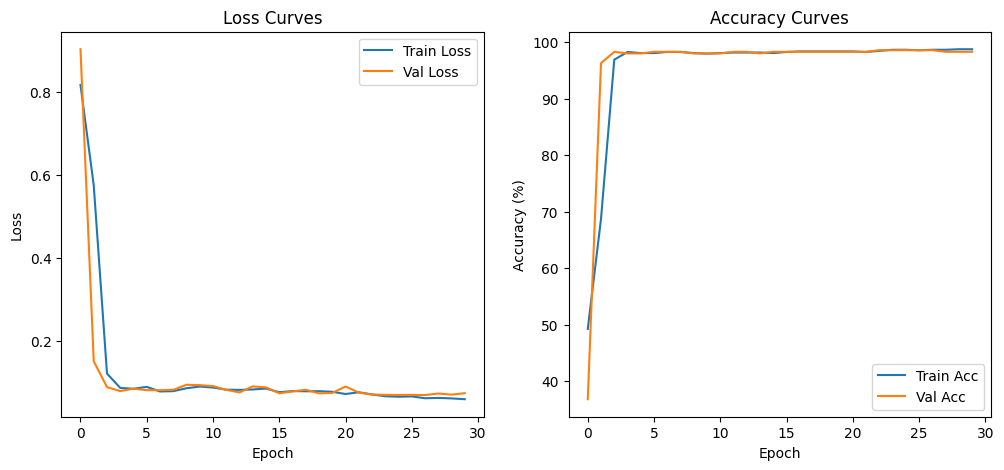

In [24]:
# Plot loss and accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.show()


In [25]:
def load_saved_checkpoint(model, optimizer, scheduler, epoch_number, device='cpu'):
    """
    Loads a checkpoint and restores the model, optimizer, scheduler, and training history.

    Args:
        model: The model instance (should be already created).
        optimizer: The optimizer instance (should be already created).
        scheduler: The scheduler instance (should be already created).
        epoch_number (int): The epoch number of the checkpoint to load.
        device (str): Device to map the checkpoint ('cpu' or 'cuda').

    Returns:
        start_epoch (int): The epoch to resume from.
        history (dict): The training/validation history up to this checkpoint.
    """
    checkpoint_path = f'checkpoint_epoch_{epoch_number}.pth'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    history = checkpoint['history']
    print(f"Resumed from epoch {start_epoch} using checkpoint '{checkpoint_path}'")
    return start_epoch, history
